In [23]:
import pandas as pd
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np

In [24]:
## Configure
SHOW_MAX_ROWS = 100
DEALS_HISTORY_FILE_NAME = "sg_20210306_history_export"
#DEALS_HISTORY_FILE_NAME = "Hazhir_20210303"
#DEALS_HISTORY_FILE_NAME = "Arun_20210227"
#DEALS_HISTORY_FILE_NAME = "Asier_20210304"
#DEALS_HISTORY_FILE_NAME = "Stefan_Ruff_20210313_bot-2791645-deals"
DEALS_HISTORY_FILE_NAME = "sg_export_20210314"
QUOTE_PAIR = "BUSD"
TRADES_MIN_TRESHOLD = 10 # Pairs with deals count less than this number will not appear in the analysis
# statistical trimming of most long and most short trades (by duration) for better averages in %
STAT_TRIM = True
TOP_TRIMMING = 0.95
BOTTOM_TRIMMING = 0.05

In [44]:
#df = df[df["bot_id"] != 2989202]
#df.loc[df["profit_percentage_from_total_volume"].idxmax()]

In [25]:
pd.set_option('display.max_rows', SHOW_MAX_ROWS)
DEALS_HISTORY_FILE_PATH = f"../resources/history_files/{DEALS_HISTORY_FILE_NAME}.csv"
COLUMNS = ["deal_id","bot_id", "status","pair","created_at", "closed_at", "duration", "profit_percentage_from_total_volume", "final_profit"]

df = pd.read_csv(DEALS_HISTORY_FILE_PATH, sep=';')
## trimm and filter
dff = df.loc[:,COLUMNS]
dff = dff[dff["status"] == "completed"]
dff = dff[dff["pair"].str.startswith(QUOTE_PAIR)]
if STAT_TRIM:
    dff = dff[dff.duration < dff.duration.quantile(TOP_TRIMMING)]
    dff = dff[dff.duration > dff.duration.quantile(BOTTOM_TRIMMING)]

In [26]:
## Aggregation
AVG_PROFIT_PER_DEAL_LABEL = "avg_profit_per_deal"
AVG_DURATION_LABEL = "avg_duration_of_deals"
AVG_PROFIT_PER_HOUR_LABEL = "avg_profit_per_hour"
COUNT_LABEL = "deals_count"

# group by pair, craete  columns average duration and average profit
dfan = dff.groupby(["pair"]).aggregate({"pair": "count", "duration": "mean", "final_profit" : "mean"})
dfan.rename(columns={"duration": AVG_DURATION_LABEL, 
                     "final_profit" : AVG_PROFIT_PER_DEAL_LABEL, 
                     "pair": COUNT_LABEL},
           inplace=True)

# filter only Pairs with decent ammount of trades
dfan = dfan[dfan[COUNT_LABEL] > TRADES_MIN_TRESHOLD]
# create new avg_profit_per_hour column
dfan[AVG_PROFIT_PER_HOUR_LABEL] = dfan[AVG_PROFIT_PER_DEAL_LABEL]/dfan[AVG_DURATION_LABEL]*60*60
# make duration human readable
#dfan[AVG_DURATION_LABEL] = dfan[AVG_DURATION_LABEL].apply(lambda x: timedelta(seconds=x))
dfan[AVG_DURATION_LABEL] = dfan[AVG_DURATION_LABEL].apply(lambda x: pd.to_timedelta(x,unit='s'))
dfan

,deals_count,avg_duration_of_deals,avg_profit_per_deal,avg_profit_per_hour
pair,,,,
BUSD_AAVE,52,02:01:34.650746,0.439922,0.217107
BUSD_ACM,11,01:13:56.242691,0.866466,0.703135
BUSD_ADA,243,02:01:17.771977,0.558408,0.276221
BUSD_AERGO,73,00:35:40.810873,0.368950,0.620428
BUSD_ALGO,33,02:24:41.501542,0.446890,0.185314
BUSD_ALPHA,40,00:36:59.479849,0.400073,0.648919
BUSD_ATOM,41,01:01:49.673177,0.607365,0.589409
BUSD_AUCTION,25,01:01:39.051144,0.613610,0.597179
BUSD_AUDIO,20,01:39:12.843263,0.685455,0.414531


In [33]:
dfplot = dfan["pair"]+dfan[COUNT_LABEL]
dfplot

KeyError: 'pair'

<AxesSubplot:title={'center':'Average deal profit per hour, sg_export_20210314'}, xlabel='pair, BUSD', ylabel='profit, $'>

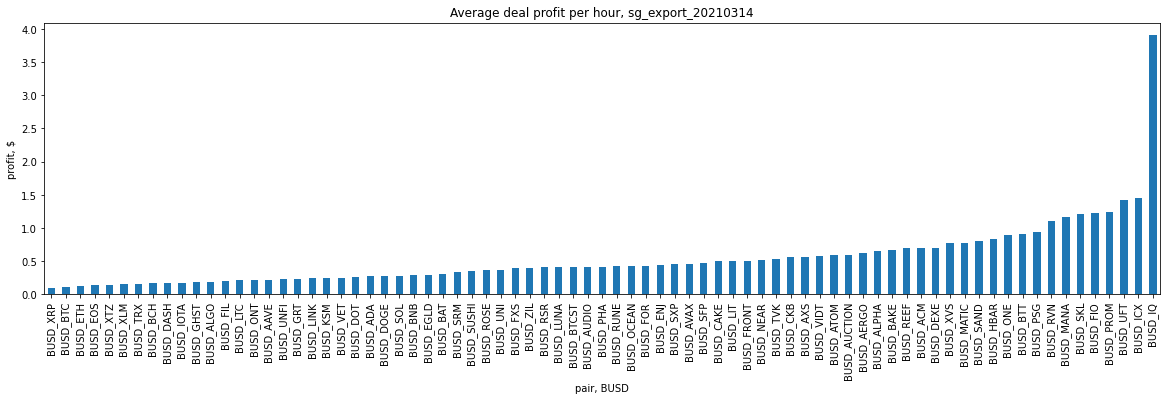

In [34]:
# Average Profit/h
pl = dfplot.sort_values(AVG_PROFIT_PER_HOUR_LABEL)[AVG_PROFIT_PER_HOUR_LABEL].plot(kind="bar",
                                                                            figsize=(20,5),
                                                                            title=f'Average deal profit per hour, {DEALS_HISTORY_FILE_NAME}')
pl.set_ylabel("profit, $")
pl.set_xlabel(f"pair, {QUOTE_PAIR}")
pl

<AxesSubplot:title={'center':'Average deal duration in minutes, sg_export_20210314'}, xlabel='pair, BUSD', ylabel='t, minutes'>

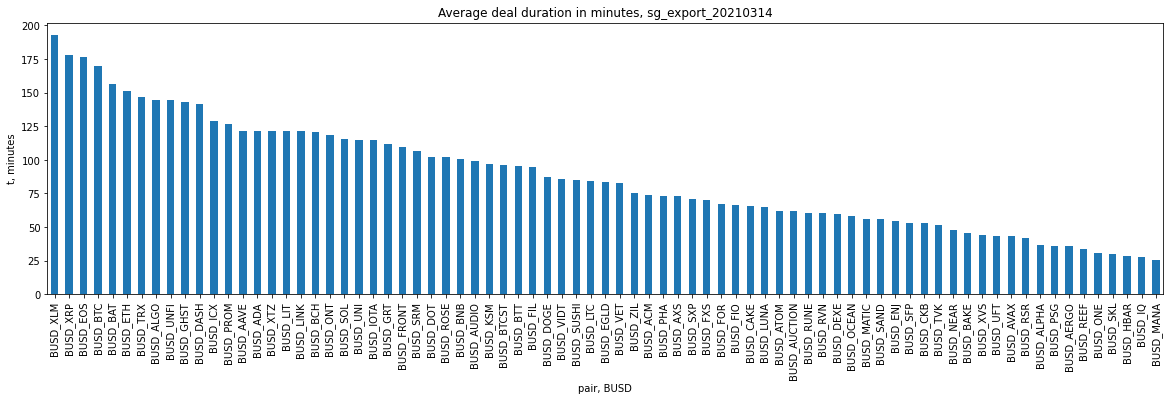

In [28]:
# Average Duration in minutes
pl = (dfan.sort_values(by=AVG_DURATION_LABEL, ascending=False)[AVG_DURATION_LABEL].dt.total_seconds()/60).plot(kind="bar",
                                                                                           figsize=(20,5),
                                                                                           title=f'Average deal duration in minutes, {DEALS_HISTORY_FILE_NAME}')
pl.set_ylabel("t, minutes")
pl.set_xlabel(f"pair, {QUOTE_PAIR}")
pl